In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
dog_bites_df = pd.read_csv('data/Dog_Bites_Data.csv')
akc_df = pd.read_csv('data/akc-data-latest.csv')

In [158]:
# eda part

In [159]:
dog_bites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UniqueID    22663 non-null  int64 
 1   DateOfBite  22663 non-null  object
 2   Species     22663 non-null  object
 3   Breed       20445 non-null  object
 4   Age         11442 non-null  object
 5   Gender      22663 non-null  object
 6   SpayNeuter  22663 non-null  bool  
 7   Borough     22663 non-null  object
 8   ZipCode     16805 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.4+ MB


In [160]:
dog_bites_df['DateOfBite'] = pd.to_datetime(df['DateOfBite'], errors='coerce')

In [161]:
dog_bites_df.head()

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,2018-01-01,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,2018-01-04,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,2018-01-06,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,2018-01-08,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,2018-01-09,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


In [162]:
dog_bites_df.isnull().sum()

UniqueID          0
DateOfBite        0
Species           0
Breed          2218
Age           11221
Gender            0
SpayNeuter        0
Borough           0
ZipCode        5858
dtype: int64

In [163]:
dog_bites_df.shape

(22663, 9)

In [164]:
dog_bites_df.describe()

,UniqueID,DateOfBite
count,22663.000000,22663
mean,5715.036668,2018-05-14 08:28:34.300842752
min,1.000000,2015-01-01 00:00:00
25%,2833.500000,2016-08-22 00:00:00
50%,5666.000000,2018-05-10 00:00:00
75%,8499.000000,2019-12-07 00:00:00
max,12383.000000,2021-12-31 00:00:00
std,3354.278369,NaN


drop id (since meaningless), species(since there is only one species). Both bread and age has null value. For the breed, since the propostion of the null value is small, will just asign unknown for the null breed. For the age, there are 50% unknown age. Should first plot the age and then decide how to deal with it. Zipcode also has null value, but has very high relationship with the broough. Maybe could just drop the whole zipcode column. 

<Axes: ylabel='Species'>

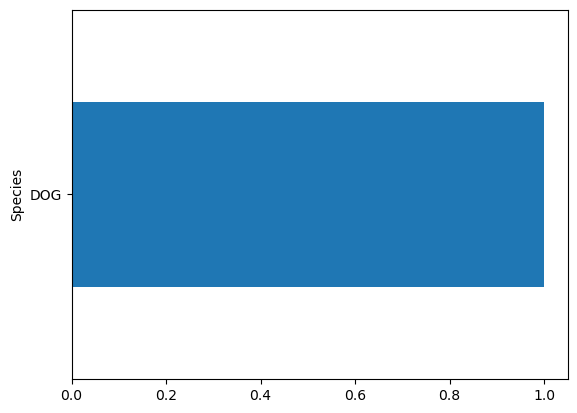

In [165]:
dog_bites_df['Species'].value_counts(normalize=True).plot.barh()

In [166]:
dog_bites_df['Breed'].describe()

count        20445
unique        1651
top       Pit Bull
freq          4004
Name: Breed, dtype: object

In [167]:
# Show the number of each distinct category of a specific feature
category_counts = dog_bites_df['Breed'].value_counts().head(40)

# Print the result
print(category_counts)

Breed
Pit Bull                                4004
UNKNOWN                                 2349
Shih Tzu                                 731
Chihuahua                                646
German Shepherd                          622
Mixed/Other                              559
American Pit Bull Mix / Pit Bull Mix     520
American Pit Bull Terrier/Pit Bull       511
Yorkshire Terrier                        480
MIXED BREED                              388
Maltese                                  371
MIXED                                    351
Rottweiler                               316
Siberian Husky                           303
Labrador Retriever                       282
Poodle, Standard                         264
Bull dog                                 220
Jack Russ                                190
Cocker Spaniel                           172
Labrador Retriever Crossbreed            160
TERRIER                                  158
Beagle                                   142
Gold

In [168]:
# Show the number of each distinct category of a specific feature
category_counts = df['Breed'].value_counts()

# Print the result
print(category_counts)

Breed
Pit Bull                 4004
UNKNOWN                  2349
Shih Tzu                  731
Chihuahua                 646
German Shepherd           622
                         ... 
BOXER/ ROTTWEILER MIX       1
MALTESE / SHIH TZU          1
SILKY MIX                   1
JINDO MIX                   1
DUNKER                      1
Name: count, Length: 1651, dtype: int64


In [169]:
# Import fuzzywuzzy library
from fuzzywuzzy import process

# Fill NaN values in the 'Breed' column with 'unknown' and convert to lowercase
dog_bites_df['Breed'] = dog_bites_df['Breed'].str.lower().fillna('unknown')

# Retry the process of creating a breed mapping dictionary
dog_bites_breeds = dog_bites_df['Breed'].str.lower().unique()  # Apply strip and lower element-wise
akc_breeds = akc_df['Unnamed: 0'].str.lower().unique()

# Function to perform fuzzy matching
def get_closest_match(breed, akc_breeds):
    match, score = process.extractOne(breed, akc_breeds)
    return match if score > 80 else None  # If the similarity score is high, return the AKC breed; otherwise return None

# Refined function to handle breed names and attempt fuzzy/substring matching
def match_breed(breed, akc_breeds):
    # Step 1: Apply fuzzy matching for entire breed name
    closest_match = get_closest_match(breed, akc_breeds)
    if closest_match:
        return closest_match
    
    # Step 2: Try substring matching
    for akc_breed in akc_breeds:
        if breed in akc_breed or akc_breed in breed:
            return akc_breed
    
    # Step 3: If no match is found, return None
    return None

# Create a mapping dictionary to standardize dog breeds based on the AKC breed list using fuzzy matching and substring matching
breed_mapping_dict = {}

# Go through all breeds in Dog Bites dataset
for breed in dog_bites_breeds:
    # Handle 'Mixed' and 'Crossbreed' cases
    if 'mix' in breed or 'crossbreed' in breed:
        breed_mapping_dict[breed] = 'mixed'
    
    # Try to match breed via fuzzy and substring matching
    else:
        matched_breed = match_breed(breed, akc_breeds)
        
        if matched_breed:  # If a match is found (fuzzy or substring)
            breed_mapping_dict[breed] = matched_breed
        else:
            # If no match is found, categorize as 'unknown'
            breed_mapping_dict[breed] = 'unknown'

# Apply the breed_mapping_dict to clean the 'Breed' column
dog_bites_df['Breed'] = dog_bites_df['Breed'].map(breed_mapping_dict)

# Replace any NaN values that resulted from mapping with 'unknown'
dog_bites_df['Breed'] = dog_bites_df['Breed'].fillna('unknown')

# Display the cleaned dataframe
dog_bites_df.head()


,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,2018-01-01,DOG,unknown,NaN,U,False,Brooklyn,11220
1,2,2018-01-04,DOG,unknown,NaN,U,False,Brooklyn,NaN
2,3,2018-01-06,DOG,bull terrier,NaN,U,False,Brooklyn,11224
3,4,2018-01-08,DOG,mixed,4,M,False,Brooklyn,11231
4,5,2018-01-09,DOG,bull terrier,NaN,U,False,Brooklyn,11224


In [170]:
breed_mapping_dict['american pit bull mix / pit bull mix']

'mixed'

In [171]:
# Show the number of each distinct category of a specific feature
category_counts = dog_bites_df['Breed'].value_counts().head(40)

# Print the result
print(category_counts)

Breed
unknown                           5264
bull terrier                      4630
mixed                             3923
shih tzu                           781
chihuahua                          697
german shepherd dog                624
yorkshire terrier                  486
maltese                            432
siberian husky                     379
rottweiler                         337
labrador retriever                 335
poodle (standard)                  265
bulldog                            261
cocker spaniel                     186
airedale terrier                   185
beagle                             179
boxer                              152
american staffordshire terrier     151
golden retriever                   144
dachshund                          137
shiba inu                          135
american english coonhound         130
pomeranian                         128
french bulldog                     111
poodle (miniature)                 108
chow chow          

In [172]:
# Show the number of each distinct category
category_counts = dog_bites_df['Breed'].value_counts()

# Print the count of unique categories
unique_category_count = dog_bites_df['Breed'].nunique()

# Print the result
print("Number of unique categories:", unique_category_count)

Number of unique categories: 175


<Axes: ylabel='Breed'>

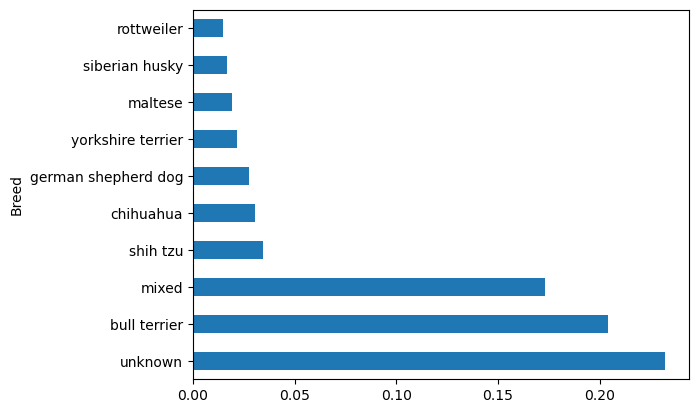

In [173]:
dog_bites_df['Breed'].value_counts(normalize=True).head(10).plot.barh()

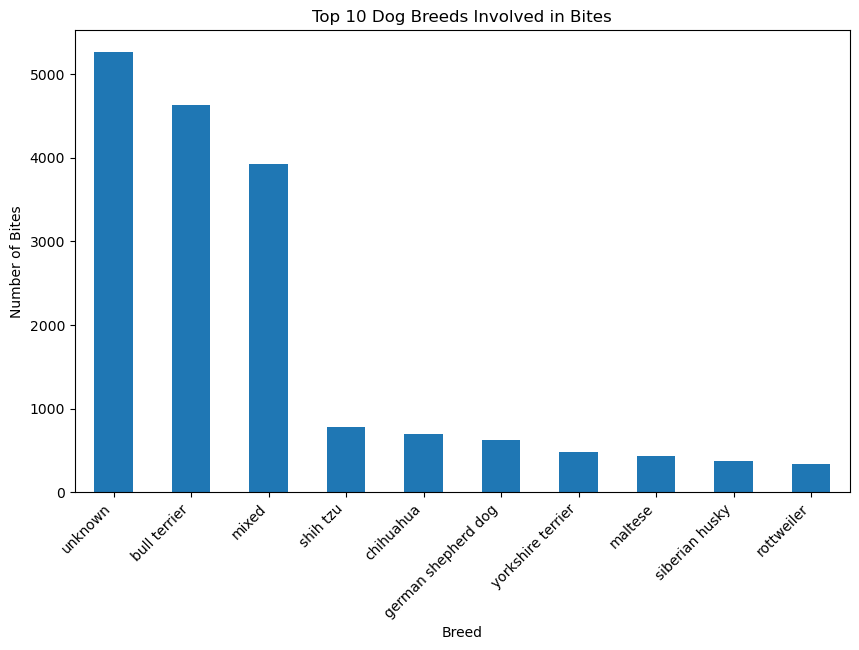

In [185]:
# Count the number of bites by breed
breed_counts = dog_bites_df['Breed'].value_counts().head(10)  # Top 10 breeds

# Bar plot for breeds
plt.figure(figsize=(10, 6))
breed_counts.plot(kind='bar')
plt.title('Top 10 Dog Breeds Involved in Bites')
plt.xlabel('Breed')
plt.ylabel('Number of Bites')
plt.xticks(rotation=45, ha='right')
plt.show()

<Figure size 640x480 with 0 Axes>

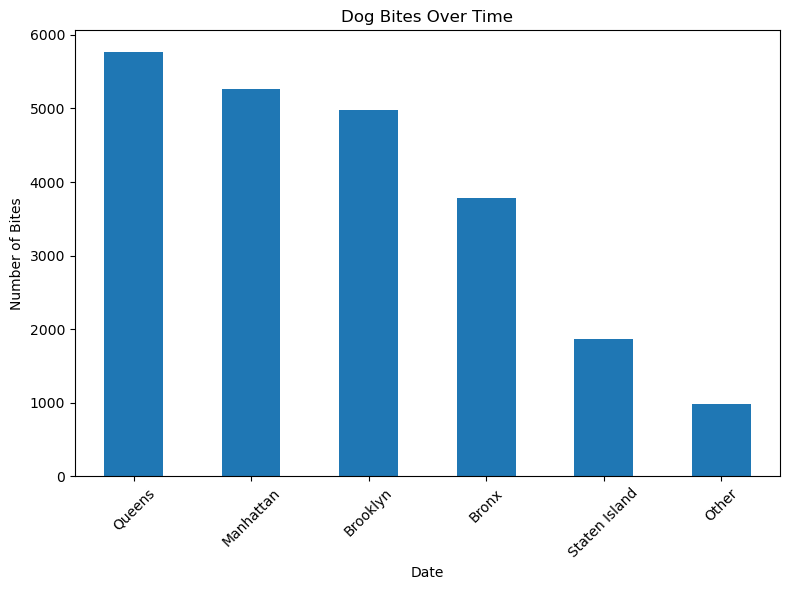

In [183]:
# Resample by month to count bites over time
bites_over_time = df.groupby(dog_bites_df['DateOfBite'].dt.to_period('M')).size()

# Line plot for dog bites over time
plt.figure()
plt.figure(figsize=(8, 6))
borough_counts.plot(kind='bar')
plt.title('Dog Bites Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Bites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

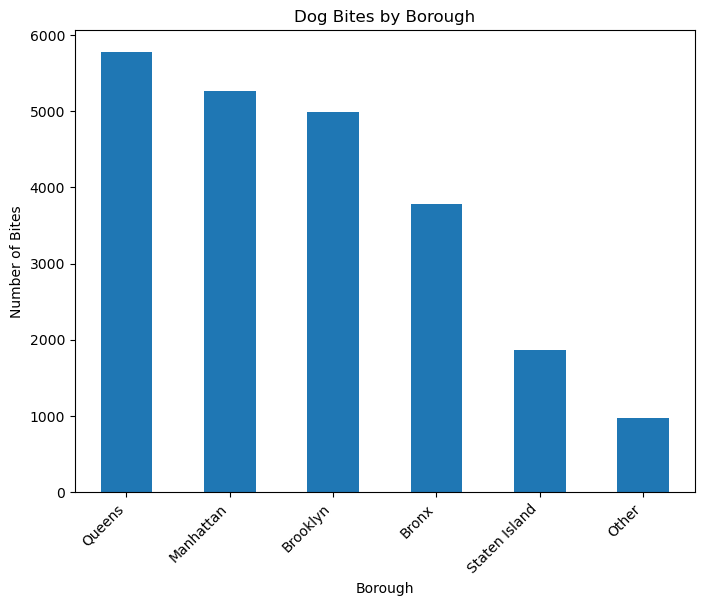

In [184]:
# Count the number of bites by borough
borough_counts = dog_bites_df['Borough'].value_counts()

# Bar plot for boroughs
plt.figure(figsize=(8, 6))
borough_counts.plot(kind='bar')
plt.title('Dog Bites by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Bites')
plt.xticks(rotation=45, ha='right')
plt.show()